In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm
import time
import os
from pathlib import Path
pd.options.mode.chained_assignment = None  # default='warn'
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import proplot as plot
plot.rc.color = 'black'
plot.rc['figure.facecolor']='white'
plot.rc.cycle = '538'
from matplotlib.patches import Rectangle

figwidth=3.25
figwidth_2col = 7
figheight = figwidth*3/4

In [2]:
pOCV = pd.read_excel('LFP_pseudo-OCV.xlsx',sheet_name=['PE','NE'])
cutoff_Vs = [2.3,4.0]
Vgrid = np.linspace(2.3,4.0,100)

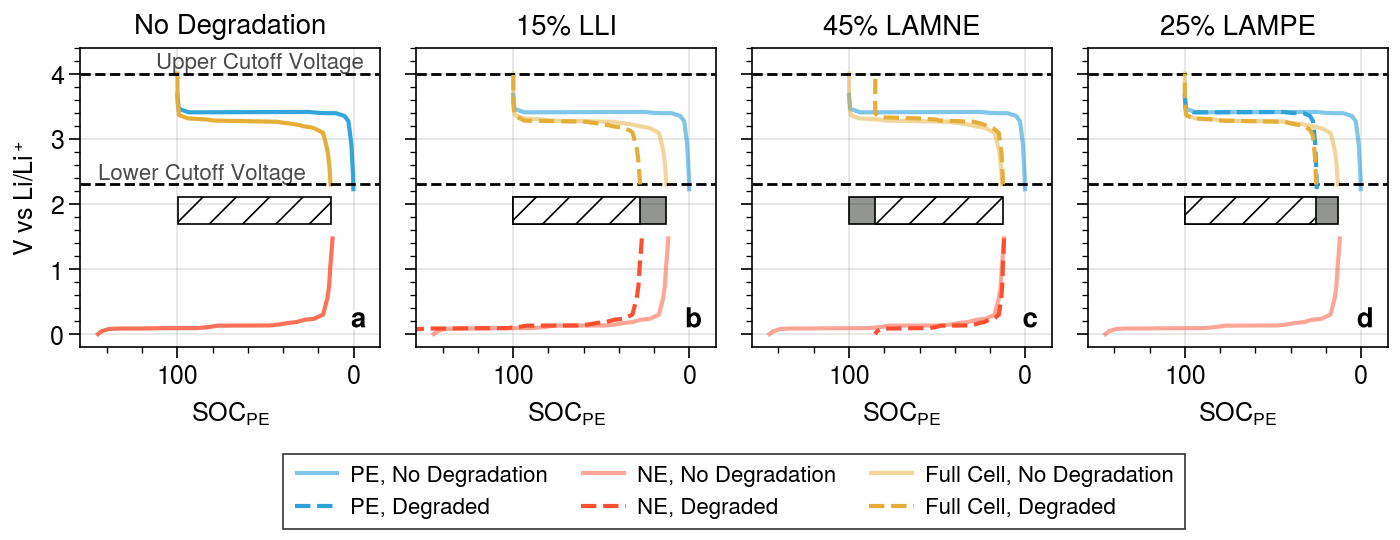

In [30]:
fig, axs = plot.subplots(nrows=1, ncols=4,spanx=False, width=figwidth_2col)#, space=0)

ax = axs[0]

PEdf = pOCV['PE'].sort_values(by=['Q'],ascending=True)
NEdf = pOCV['NE'].sort_values(by=['Q'],ascending=True)
Qgrid = np.linspace(np.min([PEdf.Q.max(),NEdf.Q.max()]),np.max([PEdf.Q.min(),NEdf.Q.min()]),100)

fOCV = interp1d(PEdf.Q,PEdf.V)
ax.plot(PEdf.Q,PEdf.V,'-',alpha=0.8)
peOCV = fOCV(Qgrid)

fOCV = interp1d(NEdf.Q,NEdf.V)
ax.plot(NEdf.Q,NEdf.V,'-',alpha=0.8)
neOCV = fOCV(Qgrid)

cellOCV = peOCV - neOCV
fOCV = interp1d(cellOCV,Qgrid,fill_value='extrapolate',bounds_error=False)
Vgrid_cut = Vgrid[Vgrid<=cellOCV.max()]
cellQ = fOCV(Vgrid_cut)
cellQ = np.concatenate((cellQ,cellQ.max()*np.ones(len(Vgrid[Vgrid>cellOCV.max()]))))
ax.plot(cellQ,Vgrid,'-',alpha=1)

ax.axhline(cutoff_Vs[0],ls='--',c='k',lw=1)
ax.axhline(cutoff_Vs[1],ls='--',c='k',lw=1)
ax.text(145,cutoff_Vs[0],'Lower Cutoff Voltage',ha='left',va='bottom',alpha=0.7,fontsize=8)
ax.text(-6,cutoff_Vs[1],'Upper Cutoff Voltage',ha='right',va='bottom',alpha=0.7,fontsize=8)
ax.add_patch(Rectangle((cellQ[-1], 1.7), cellQ[0]-cellQ[-1], 0.4,fc='w',ec='k',alpha=1,hatch='//'))
for ax in axs[1:]:

    ax.plot(PEdf.Q,PEdf.V,'-',alpha=0.5,label='PE, No Degradation')
    ax.plot(NEdf.Q,NEdf.V,'-',alpha=0.5,label='NE, No Degradation')
    ax.plot(cellQ,Vgrid,'-',alpha=0.5,label='Full Cell, No Degradation')
    
    ax.add_patch(Rectangle((cellQ[-1], 1.7), cellQ[0]-cellQ[-1], 0.4,fc='gray',ec='k',alpha=1))

    ax.axhline(cutoff_Vs[0],ls='--',c='k',lw=1)
    ax.axhline(cutoff_Vs[1],ls='--',c='k',lw=1)
    
ax = axs[1]

PEdf = pOCV['PE'].sort_values(by=['Q'],ascending=True)
NEdf = pOCV['NE'].sort_values(by=['Q'],ascending=True)
NEdf.Q += 15
Qgrid = np.linspace(np.min([PEdf.Q.max(),NEdf.Q.max()]),np.max([PEdf.Q.min(),NEdf.Q.min()]),100)

fOCV = interp1d(PEdf.Q,PEdf.V)
peOCV = fOCV(Qgrid)

fOCV = interp1d(NEdf.Q,NEdf.V)
ax.plot(NEdf.Q,NEdf.V,'--',color='#fc4f30',alpha=1)
neOCV = fOCV(Qgrid)

cellOCV = peOCV - neOCV
fOCV = interp1d(cellOCV,Qgrid,fill_value='extrapolate',bounds_error=False)
Vgrid_cut = Vgrid[Vgrid<=cellOCV.max()]
cellQ = fOCV(Vgrid_cut)
cellQ = np.concatenate((cellQ,cellQ.max()*np.ones(len(Vgrid[Vgrid>cellOCV.max()]))))
ax.plot(cellQ,Vgrid,'--',color='#e5ae38',alpha=1)

ax.add_patch(Rectangle((cellQ[-1], 1.7), cellQ[0]-cellQ[-1], 0.4,fc='w',ec='k',alpha=1,hatch='//'))


ax = axs[2]

PEdf = pOCV['PE'].sort_values(by=['Q'],ascending=True)
NEdf = pOCV['NE'].sort_values(by=['Q'],ascending=True)
NEdf.Q = NEdf.Q.min() + 0.55*(NEdf.Q-NEdf.Q.min())
Qgrid = np.linspace(np.min([PEdf.Q.max(),NEdf.Q.max()]),np.max([PEdf.Q.min(),NEdf.Q.min()]),100)

fOCV = interp1d(PEdf.Q,PEdf.V)
peOCV = fOCV(Qgrid)

fOCV = interp1d(NEdf.Q,NEdf.V)
ax.plot(NEdf.Q,NEdf.V,'--',color='#fc4f30',alpha=1,label='NE, Degraded')
neOCV = fOCV(Qgrid)

h, l = ax.get_legend_handles_labels()

cellOCV = peOCV - neOCV
fOCV = interp1d(cellOCV,Qgrid,fill_value='extrapolate',bounds_error=False)
Vgrid_cut = Vgrid[Vgrid<=cellOCV.max()]
cellQ = fOCV(Vgrid_cut)
cellQ = np.concatenate((cellQ,cellQ.max()*np.ones(len(Vgrid[Vgrid>cellOCV.max()]))))
ax.plot(cellQ,Vgrid,'--',color='#e5ae38',alpha=1,label='Full Cell, Degraded')

ax.add_patch(Rectangle((cellQ[-1], 1.7), cellQ[0]-cellQ[-1], 0.4,fc='w',ec='k',alpha=1,hatch='//'))


ax = axs[3]

PEdf = pOCV['PE'].sort_values(by=['Q'],ascending=True)
NEdf = pOCV['NE'].sort_values(by=['Q'],ascending=True)
PEdf.Q = 0.75*(PEdf.Q - PEdf.Q.max()) + PEdf.Q.max() 
Qgrid = np.linspace(np.min([PEdf.Q.max(),PEdf.Q.max()]),np.max([PEdf.Q.min(),PEdf.Q.min()]),100)

fOCV = interp1d(PEdf.Q,PEdf.V)
peOCV = fOCV(Qgrid)

fOCV = interp1d(NEdf.Q,NEdf.V)
ax.plot(PEdf.Q,PEdf.V,'--',color='#30a2da',alpha=1,label='PE, Degraded')
neOCV = fOCV(Qgrid)

cellOCV = peOCV - neOCV
fOCV = interp1d(cellOCV,Qgrid,fill_value='extrapolate',bounds_error=False)
Vgrid_cut = Vgrid[Vgrid<=cellOCV.max()]
cellQ = fOCV(Vgrid_cut)
cellQ = np.concatenate((cellQ,cellQ.max()*np.ones(len(Vgrid[Vgrid>cellOCV.max()]))))
ax.plot(cellQ,Vgrid,'--',color='#e5ae38',alpha=1,label='Full Cell, Degraded')

ax.add_patch(Rectangle((cellQ[-1], 1.7), cellQ[0]-cellQ[-1], 0.4,fc='w',ec='k',alpha=1,hatch='//'))



hlist, llist = ax.get_legend_handles_labels()
hlist.insert(-1,h[-1])
llist.insert(-1,l[-1])

for ax,title in zip(axs,['No Degradation','15% LLI','45% LAMNE','25% LAMPE']):
    ax.format(title=title)
    ax.set_xlim(155,-15)
    ax.set_ylim(ax.get_ylim()[0],4.4)
    
fig.legend(loc='b',handles=hlist,labels=llist,fontsize=8)
axs.format(
    abc=True, abcloc='lr', xlabel='$SOC_{PE}$', ylabel='$V$ vs $Li/Li^+$',
)

fig.savefig('figures/degradation_mode_examples.png',dpi=300,transparent=True)